This is most a copy/paste of the plotTPDdata program I wrote, but more specifically to check out calcs for the GUA area


In [27]:
%matplotlib notebook
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.axes as axes
import numpy as np
# import scipy.integrate
from scipy import integrate
import re
from init_info import *
from collections import defaultdict
import os
# import seaborn as sns

In [2]:

# TODO will append the langmuirs to this list
langmuir = []
# keep area dict empty
area_dict = defaultdict(list)
filename_list = []

def rename_to_text(file_path):
    """
    Appends a .txt to all files run since some output files do not have an extension

    :param file_path: input file path
    :return: .txt appended to end of file name
    """
    import os
    file = file_path.split('/')[-1]
    if file.endswith('.txt') is False:
        new_file_name = file_path+'.txt'
        os.rename(file_path, new_file_name)
        file_path = new_file_name
    filename = file
    return file_path, filename


def single_slope_subtract(file__read, num_points_to_average_beg=50, num_points_to_average_end=50):
    """
    Averages points at the beginning and end of a file and subtracts the line between the two points from the data to
    subtract a background.
    :param file__read: df of file
    :param num_points_to_average_beg: number of points to average from the beginning of the dataset
    :param num_points_to_average_end: number of points to average from the end of the dataset
    :return: new_file_read, which is the background subtracted data
    """

    # mean of first N points
    avg_y_beg = file__read.iloc[:num_points_to_average_beg].mean()

    # mean of last N points
    avg_y_end = file__read.iloc[-num_points_to_average_end:].mean()

    # x value for beginning (assume first xval)
    first_xval = file__read.first_valid_index()

    # x value for ending (assume last xval)
    last_xval = file__read.last_valid_index()

    slope = (avg_y_end - avg_y_beg) / (last_xval - first_xval)
    # y' = mx
    # caveat...only works with monitoring a single mass-- update 7/13/17 appears to have fixed this...
    # y_prime = pd.DataFrame(slope.values * file_read.index.values, columns=file_read.columns)

    y_prime = pd.DataFrame(np.matmul(file__read.index.values[:, np.newaxis], np.transpose(slope.values[:, np.newaxis])),
                           columns=file__read.columns)

    y_prime.index = file__read.index

    # first attempt at fix
    # y_prime = slope.values[0]*file_read.index+avg_y_beg
    # ynew = y - m_hat*x
    difference = file__read - y_prime
    difference = difference - difference.iloc[:(num_points_to_average_beg)].mean()

    new_file_read = difference

    return new_file_read

def plot_same_masses(dict__values, file_name, new__file__read, area_dict):
    """
    Plots the same masses together in a matploblib figure. It also feeds into uptake area to calculate the area
    under the curve for a particular mass
    :param dict__values: dictionary of masses
    :param file_name: name of the file
    :param new__file__read: dataframe of the data in the file
    :return: outputs a plot
    """
    i = 0
    # for key, value in dict__values.items():
    for colname in new__file__read.columns:
        try:
            i += 1
            # mass_data = new__file__read.filter(regex=str(value))


            # key = dict__values[new__file__read.columns[0].split('=')[1]]
            try:
                key = dict__values[new__file__read[colname].name.split('=')[1]]
            except IndexError:
                # if the file is a hiden file do the following below...
                key = dict__values[new__file__read[colname].name]
            mass_data = new__file__read[colname]
            # mass_data = new__file__read.columns[colname].split('=')[1]
            fig = plt.figure(figsize=(15, 7), num=key)
            ax = fig.add_subplot(111)
            ax.tick_params(direction='out', length=6, width=2, colors='k')

            if monochrome:
                ax.plot(mass_data, label=file_name, linewidth=2, color='k')
                if file_name == monolayer:
                    ax.plot(mass_data, label=file_name, linewidth=2, color='r')
            else:
                ax.plot(mass_data, label=file_name, linewidth=2)
            plt.ylabel('QMS signal (a.u.)')
            plt.xlabel('Temperature (K)')
            plt.title(key + '/' + surface + ' TPD')

            plt.minorticks_on()
            plt.tick_params(which='minor', length=4, width=1.5)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            # iterate i to change the figure number for the different mass
            # ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
            # ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
            # ax.grid(b=True, which='major', color='w', linewidth=1.0)
            # ax.grid(b=True, which='minor', color='w', linewidth=0.5)

            # new__file__read.rename(columns={new__file__read.filter(regex=str(value)).columns[0]: key}, inplace=True)
            new__file__read.rename(columns={new__file__read[colname].name: key}, inplace=True)
            mass_data.columns = [key]
            """
            # work in progress
            # TODO add these areas to a list or ordered dictionary
            #     add these areas to a list or ordered dictionary
            "for exporting data with masses concatenated"
            export_dict = dict()
            tempcol = new__file__read.columns
            # new__file__read.columns = [file_name]*len(tempcol)

            for col in tempcol:
                placeholder = new__file__read[col].copy()
                placeholder.name = file_name
                export_dict.setdefault(col, []).append(placeholder)
                # print(placeholder.head())
            """
            if legend_disp =='on':
                plt.legend()
            if use_temp_limits is True:
                axes.Axes.set_xlim(plt.gca(), left=low_temp, right=high_temp)
            integrate_area = uptake_area(mass_data, key, temp_ranges=temp_values, slope_subtract=slope_subtract)
            # print(str(int(integrate_area))+' area for ' + key)
            print(str((integrate_area))+' area for ' + key)

            plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


        except ZeroDivisionError or KeyError:
            if ax.has_data() is False:
                plt.close(fig)
            # print('ZeroDivisionError: integer division or modulo by zero')
            print('Mass: ' + key + ' not found in ' + file_name)
            # integrate_area = -1
            integrate_area = 0
    #         TODO
    #         if the mass is not in the file, we still need to add an empty element to the area for that particular mass
    #         this way when another file is read that contains the mass, the order is not lost
    #         add these areas to a list or ordered dictionary

    #     now add this area to the dictionary
        area_dict[key].append(integrate_area)
        # area_dict[key].append(int(integrate_area))


    # return new__file__read, area_dict
    return area_dict


def uptake_area(mass_data, key, temp_ranges, slope_subtract = True):
    """

    :param mass_data: Data from the particular mass
    :param key: The name of the mass, ex. HOAc
    :param temp_ranges: The temperature range you want to take the area under the curve. This area is slope subtracted.
    :return: Area under the curve
    """
    # slope_subtract = True

    try:
        lower_index1 = str(temp_ranges[key][0])
        upper_index1 = str(temp_ranges[key][1])
        if type(mass_data) == pd.core.frame.DataFrame:
            mass_data = mass_data.query('index >' + lower_index1 + ' & index < ' + upper_index1)
            if slope_subtract is True:
                # slope subtraction?
                mass_data = single_slope_subtract(mass_data, num_points_to_average_beg=2,num_points_to_average_end=2 )

            area_under_curve = integrate.trapz(mass_data, x=mass_data.index, axis=0)[0]
        elif type(mass_data) == pd.core.series.Series:
            # mass_data = mass_data[float(lower_index1): float(upper_index1)]

            mass_data = mass_data.to_frame().query('index >' + lower_index1 + ' & index < ' + upper_index1)[
                mass_data.name]
            if slope_subtract is True:
            # slope subtraction?
                mass_data = single_slope_subtract(mass_data.to_frame(), num_points_to_average_beg=2, num_points_to_average_end=2)
                mass_data = mass_data - mass_data.min()
                area_under_curve = integrate.trapz(mass_data, x=mass_data.index, axis=0)[0]
            else:
                area_under_curve = integrate.trapz(mass_data)

        # The area below was calculated from a saturation dose of CO adsorbed on Pt(100)-hex
        # area_under_curve/=sat_CO_area_Pt
        # area_under_curve/=2253432

        # mass_data.plot()
    except KeyError:
        # area_under_curve = -1
        area_under_curve = 0

    return area_under_curve


def langmuir_determination(filename):
    """
    lets look at the naming conventions for the files
    example: '6_6_2017_AA_0.015 L.txt'
    or 'HOAc_6E-09_150 s _718_high_point_density.txt'
    In the first case, the dose is in the name, in the second case, we have to calculate the dose
    assuming background is zero torr...so this is the dosing pressure...

    For reference: 1 Langmuir(L) = 1e-6 torr * seconds and is a unit of exposure
    :param filename: Name of the experiment file. We assume the name of the file has the info to calculate the exposure
    :return: langmuir: the exposure for the experiment
    """
    try:
        if 'L' in filename:
            idx1 = filename[::-1].find('_')
            idx2 = filename[::-1].find('L')

            # files =filename[-idx1:-idx2]
            langmuir = float(''.join(i for i in filename[-idx1:-idx2] if i.isdigit() or i == '.'))
            print(str(langmuir))

        else:
            # please make sure your file has the name written right...
            underscore = [m.start() for m in re.finditer('_', filename)]
            dose = float(filename[underscore[0] + 1: underscore[1]])
            time_s = float(re.sub('\D', '', filename[underscore[1] + 1: underscore[2]]))
            langmuir = dose*time_s/(1e-6)
            print(str(langmuir))
    except ValueError:
        langmuir = 0
        print("uh oh, I can't figure out how many langmuir this file is.")
        print("Setting langmuir to zero")

    return langmuir


def area_table_fig(area_dictionary=area_dict):
    """
    Makes a nice looking figure of the areas
    :param area_dictionary: area dictionary calculated by integrating the areas under the curve
    :return:
    """
    # fig, ax = plt.subplots(num='Area Table', figsize=(20, 7))
    fig, ax = plt.subplots(num='Area Table')

    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    # df_areadata = pd.DataFrame.from_dict(area_dictionary)
    df = pd.DataFrame.from_dict(area_dictionary)

    # df_filelist = pd.DataFrame(file_list, columns=['File'])

    # df = df_filelist.join(df_areadata)

    ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

    # tabla = plt.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center', bbox=[0, 0, 1,1])
    # tabla.auto_set_font_size(False)
    # tabla.set_fontsize(14)

    # fig.tight_layout()
    # we dont want to show the plots till the end
    # plt.show()


def read_files(file):
    # TODO Fix search into the dictionary for increased speed
    """
    1. Reads in the files and does quick cleaning
    2. sets the temperature as the index
    :param file: .txt file of the data
    :return:
    """
    file_path, filename = rename_to_text(file)
    print('\n\n')
    print(file_path)
    print('\n\n')
    # find the exposure (L)
    # langmuir.append(langmuir_determination(filename=filename))
    try:
        # read file
        file_read = pd.read_csv(file_path, sep='\t', header=3)

        # remove whitespace
        column_names = [file_read.keys()[i].lstrip() for i in range(0, len(file_read.keys()))]
        # rename columns
        file_read.columns = column_names
        # drop the time column and mse=8
        # file_read = file_read.drop([column_names[0], column_names[-1]], axis=1)
        file_read = file_read.drop([column_names[0]], axis=1)
        temp = file_read[file_read != 0]
        temp = temp.dropna(axis=0)


        file_read = file_read.dropna(axis=1)

        # for the bug in the labview that the temperature cuts out
        temp = file_read[file_read != 0]
        file_read = temp.dropna(axis=0)

        # set the index to be temperature
        file_read = file_read.set_index(file_read.keys()[0])
    except IndexError:
        "except it is a hiden mass spec file!"
        file_read = pd.read_csv(file_path, header=29)
        file_read = file_read.dropna(axis=1)
        file_read.drop(['Time', 'ms'],axis=1, inplace=True)
        file_read.set_index('Temperature', inplace=True)
    # pseudo code...
    # pd.DataFrame(molecule_area[i], index=langmuir) and append all of them

    return file_read, filename

def export_data(corrected_data_file, filename):
    writer = pd.ExcelWriter(filename + ' TPD_output ' + single_molecule_name+'.xlsx')
    corrected_data_file.to_excel(writer, 'Sheet1')
    writer.save()

In [20]:
os.chdir('C:\\Users\\manolis\\Desktop\\PycharmProjects\IRAS\\IRAS\\GUA work\\Pt(100)\\IR chamber\\TPD data\\exported data')
os.getcwd()
# test for iterating later on...
for file in os.listdir():
    print(file)
# file_read, filename = read_files(file=file)

0 L TPD_output Guaiacol.xlsx
0.0015 L TPD_output Guaiacol.xlsx
0.0025 L TPD_output Guaiacol.xlsx
0.005 L TPD_output Guaiacol.xlsx
0.0075 L TPD_output Guaiacol.xlsx
0.01 L TPD_output Guaiacol.xlsx
0.015 L TPD_output Guaiacol.xlsx
0.025 L TPD_output Guaiacol.xlsx
0.035 L TPD_output Guaiacol.xlsx
0.05 L TPD_output Guaiacol.xlsx
0.09 L TPD_output Guaiacol.xlsx
0.15 L TPD_output Guaiacol.xlsx


<IPython.core.display.Javascript object>


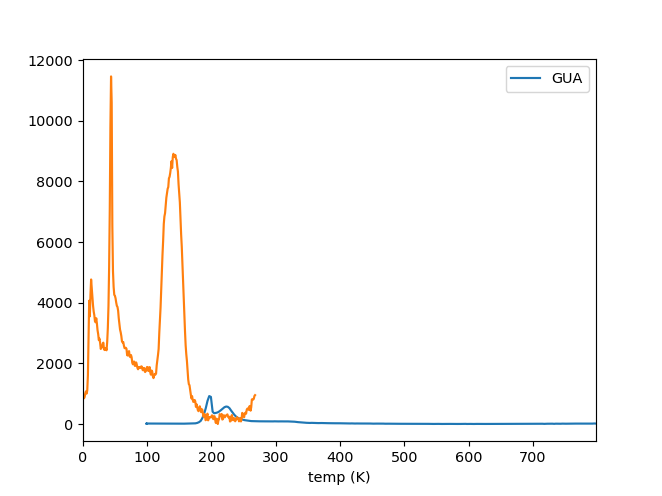

In [67]:
# 'GUA': (150,375) -> total
# 'GUA' : (150,208)-> multilayer
# 'GUA': (260,3375) -> recombinative peak
# 'GUA': (208,260) -> 2nd physisorbed layer
# data= pd.read_excel(file)

data = pd.read_excel('0.035 L TPD_output Guaiacol.xlsx')
data.plot('temp (K)','GUA')

In [64]:
# data_uptake_0_15L = uptake_area('GUA', mass_data=data.GUA, slope_subtract=False, temp_ranges=(150,212))
temp = pd.concat([data['temp (K)'],data['GUA']],axis=1)
temp.set_index('temp (K)', inplace = True)

In [65]:
mass_data = temp.query('index >' + str(150) + ' & index < ' + str(208))
print(mass_data)

                 GUA
temp (K)            
151.5      11.948507
154.6      11.351062
157.7      11.102616
160.7      12.405056
163.7      10.718496
166.6      12.272821
169.4      13.346032
172.3      15.671357
175.1      21.814568
177.9      34.691778
180.7      59.272989
183.4     102.039085
185.8     187.290836
188.5     319.045932
191.3     520.331143
194.0     761.415239
196.7     921.080335
199.3     893.604316
202.0     404.869412
204.3     354.786049
207.0     365.851145


In [66]:
integrate.trapz(x = mass_data.index[:,np.newaxis], y = mass_data, axis = 0)
# np.shape(mass_data.index[:,np.newaxis])

array([ 12899.15319699])

In [105]:
file_list =[]
multi_list = []

for file in os.listdir():
    data = pd.read_excel(file)
    print(file)
    file_list.append(file)
    temp = pd.concat([data['temp (K)'],data['GUA']],axis=1)
    temp.set_index('temp (K)', inplace = True)
    mass_data = temp.query('index >' + str(150) + ' & index <= ' + str(208))
    print(integrate.trapz(x = mass_data.index[:,np.newaxis], y = mass_data, axis = 0))

    multi_list.append(integrate.trapz(x = mass_data.index[:,np.newaxis], y = mass_data, axis = 0)[0])

0 L TPD_output Guaiacol.xlsx
[ 252.38573202]
0.0015 L TPD_output Guaiacol.xlsx
[ 340.82929272]
0.0025 L TPD_output Guaiacol.xlsx
[ 351.70541423]
0.005 L TPD_output Guaiacol.xlsx
[ 767.76667404]
0.0075 L TPD_output Guaiacol.xlsx
[ 1031.13383067]
0.01 L TPD_output Guaiacol.xlsx
[ 3865.32694347]
0.015 L TPD_output Guaiacol.xlsx
[ 5849.1510935]
0.025 L TPD_output Guaiacol.xlsx
[ 11453.00449646]
0.035 L TPD_output Guaiacol.xlsx
[ 12899.15319699]
0.05 L TPD_output Guaiacol.xlsx
[ 24240.86653524]
0.09 L TPD_output Guaiacol.xlsx
[ 56280.06865357]
0.15 L TPD_output Guaiacol.xlsx
[ 124473.812517]


In [106]:
# 'GUA': (150,375) -> total
# 'GUA' : (150,208)-> multilayer
# 'GUA': (208,260) -> 2nd physisorbed layer
# 'GUA': (260,375) -> recombinative peak

second_peak_list = []
file_list = []
for file in os.listdir():
    data = pd.read_excel(file)
    print(file)
    file_list.append(file)
    temp = pd.concat([data['temp (K)'],data['GUA']],axis=1)
    temp.set_index('temp (K)', inplace = True)
    mass_data = temp.query('index >' + str(208) + ' & index <= ' + str(260))
    print(integrate.trapz(x = mass_data.index[:,np.newaxis], y = mass_data, axis = 0))
    second_peak_list.append(integrate.trapz(x = mass_data.index[:,np.newaxis], y = mass_data, axis = 0)[0])

0 L TPD_output Guaiacol.xlsx
[ 166.77353836]
0.0015 L TPD_output Guaiacol.xlsx
[ 831.16373679]
0.0025 L TPD_output Guaiacol.xlsx
[ 1672.71834976]
0.005 L TPD_output Guaiacol.xlsx
[ 3354.10184522]
0.0075 L TPD_output Guaiacol.xlsx
[ 3722.078596]
0.01 L TPD_output Guaiacol.xlsx
[ 7400.62226052]
0.015 L TPD_output Guaiacol.xlsx
[ 10137.222658]
0.025 L TPD_output Guaiacol.xlsx
[ 14435.33367448]
0.035 L TPD_output Guaiacol.xlsx
[ 16322.07762286]
0.05 L TPD_output Guaiacol.xlsx
[ 21673.84438069]
0.09 L TPD_output Guaiacol.xlsx
[ 35169.3714737]
0.15 L TPD_output Guaiacol.xlsx
[ 63010.64673958]


In [107]:
# 'GUA': (150,375) -> total
# 'GUA' : (150,208)-> multilayer
# 'GUA': (208,260) -> 2nd physisorbed layer
# 'GUA': (260,375) -> recombinative peak

recomb_peak_list = []
file_list =[]

for file in os.listdir():
    data = pd.read_excel(file)
    print(file)
    file_list.append(file)
    temp = pd.concat([data['temp (K)'],data['GUA']],axis=1)
    temp.set_index('temp (K)', inplace = True)
    mass_data = temp.query('index >' + str(260) + ' & index <= ' + str(375))
    print(integrate.trapz(x = mass_data.index[:,np.newaxis], y = mass_data, axis = 0))
    recomb_peak_list.append(integrate.trapz(x = mass_data.index[:,np.newaxis], y = mass_data, axis = 0)[0])

0 L TPD_output Guaiacol.xlsx
[ 220.80765153]
0.0015 L TPD_output Guaiacol.xlsx
[ 1157.62643133]
0.0025 L TPD_output Guaiacol.xlsx
[ 1539.3278503]
0.005 L TPD_output Guaiacol.xlsx
[ 2134.09144043]
0.0075 L TPD_output Guaiacol.xlsx
[ 2220.14862238]
0.01 L TPD_output Guaiacol.xlsx
[ 3413.81507205]
0.015 L TPD_output Guaiacol.xlsx
[ 5171.9690907]
0.025 L TPD_output Guaiacol.xlsx
[ 6545.43217236]
0.035 L TPD_output Guaiacol.xlsx
[ 7722.99084154]
0.05 L TPD_output Guaiacol.xlsx
[ 10745.84696374]
0.09 L TPD_output Guaiacol.xlsx
[ 16096.60235996]
0.15 L TPD_output Guaiacol.xlsx
[ 29920.60164541]


In [108]:
# 'GUA': (150,375) -> total
# 'GUA' : (150,208)-> multilayer
# 'GUA': (208,260) -> 2nd physisorbed layer
# 'GUA': (260,375) -> recombinative peak

total_list = []
file_list =[]

for file in os.listdir():
    data = pd.read_excel(file)
    print(file)
    file_list.append(file)
    temp = pd.concat([data['temp (K)'],data['GUA']],axis=1)
    temp.set_index('temp (K)', inplace = True)
    mass_data = temp.query('index >' + str(150) + ' & index <= ' + str(375))
    print(integrate.trapz(x = mass_data.index[:,np.newaxis], y = mass_data, axis = 0))
    total_list.append(integrate.trapz(x = mass_data.index[:,np.newaxis], y = mass_data, axis = 0)[0])

0 L TPD_output Guaiacol.xlsx
[ 660.82306167]
0.0015 L TPD_output Guaiacol.xlsx
[ 2387.54059582]
0.0025 L TPD_output Guaiacol.xlsx
[ 3640.35271217]
0.005 L TPD_output Guaiacol.xlsx
[ 6461.82309424]
0.0075 L TPD_output Guaiacol.xlsx
[ 7198.95501224]
0.01 L TPD_output Guaiacol.xlsx
[ 15193.58791961]
0.015 L TPD_output Guaiacol.xlsx
[ 21861.90205266]
0.025 L TPD_output Guaiacol.xlsx
[ 33445.66043865]
0.035 L TPD_output Guaiacol.xlsx
[ 38210.03260135]
0.05 L TPD_output Guaiacol.xlsx
[ 58539.34912661]
0.09 L TPD_output Guaiacol.xlsx
[ 110794.17802289]
0.15 L TPD_output Guaiacol.xlsx
[ 225803.68455997]


In [109]:
df = pd.DataFrame({'total':total_list, 'multilayer':multi_list, 'secondpeak':second_peak_list, 'recomb':recomb_peak_list, 'file':file_list})
df.head()

,file,multilayer,recomb,secondpeak,total
0,0 L TPD_output Guaiacol.xlsx,252.385732,220.807652,166.773538,660.823062
1,0.0015 L TPD_output Guaiacol.xlsx,340.829293,1157.626431,831.163737,2387.540596
2,0.0025 L TPD_output Guaiacol.xlsx,351.705414,1539.327850,1672.718350,3640.352712
3,0.005 L TPD_output Guaiacol.xlsx,767.766674,2134.091440,3354.101845,6461.823094
4,0.0075 L TPD_output Guaiacol.xlsx,1031.133831,2220.148622,3722.078596,7198.955012


In [112]:
writer = pd.ExcelWriter('Vertical line integrated GUA area TPD_output .xlsx')
df.to_excel(writer, 'Sheet1')
writer.save()


<IPython.core.display.Javascript object>


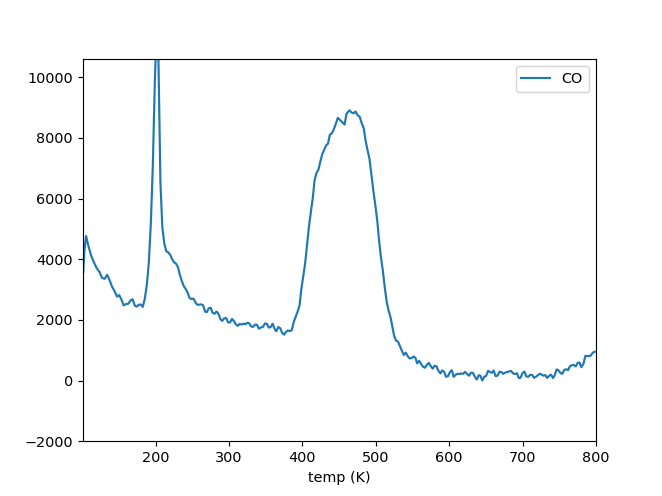

In [116]:
data.plot('temp (K)', 'CO')